In [1]:
#@Chhy

#Script to pick up and crop frames from the raw data.

# files location and name

data_file = './Data/ma6002/'
main_file = data_file + 'WMG LNO SC_1 4200mV_BCDI.h5'
flat_field_file = data_file + 'ff_20240423-0736/ff.npz'
EMC_file = './Data/EMC_results/'

save_root = './Data/pick_up/'

# interested scan 

scan_numbers = [6, 9, 12, 15, 18, 21, 24, 27, 30, 33]
emc_scan_numbers = [6, 9, 12, 15, 18, 21, 24, 27, 30]

select_scan = 6
begin, end = 300, -126

In [2]:
import hdf5plugin
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import sys, os

def normalize_1d(data):
    norm_ = (data - data.min())/(data.max()-data.min())
    return norm_

### flat field in log mod

/tmp/ipykernel_3237026/33676993.py:4: RuntimeWarning: divide by zero encountered in log10
  axs.imshow(np.log10(flat_field_))


Text(0.5, 1.0, 'Flat field in Log')

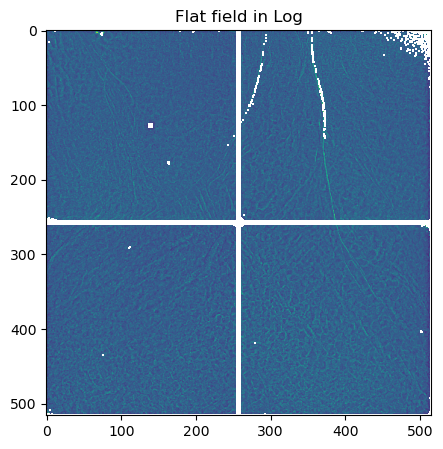

In [3]:
flat_field_ = np.load(flat_field_file)['arr_0'][:]

fig, axs = plt.subplots(1,1, figsize=(5, 5))
axs.imshow(np.log10(flat_field_))
axs.set_title('Flat field in Log')

### rocking curves of ori data

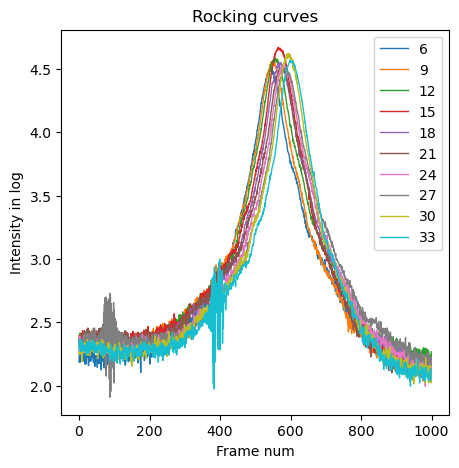

In [4]:
fig, ax = plt.subplots(1,1, figsize=(5, 5))
ax.set_title('Rocking curves')
ax.set_xlabel('Frame num')
ax.set_ylabel('Intensity in log')
for scan in scan_numbers:
    with h5py.File(main_file) as fp:
        rc_temp_ = fp['%i.1/plotselect/mpxgaas_target'%scan][:]

    ax.plot(np.log10(rc_temp_), label='%i'%scan, linewidth=1)
ax.legend()

### rocking curves of corrected data

[0 0 2 0 0 1 2 2 4] 128


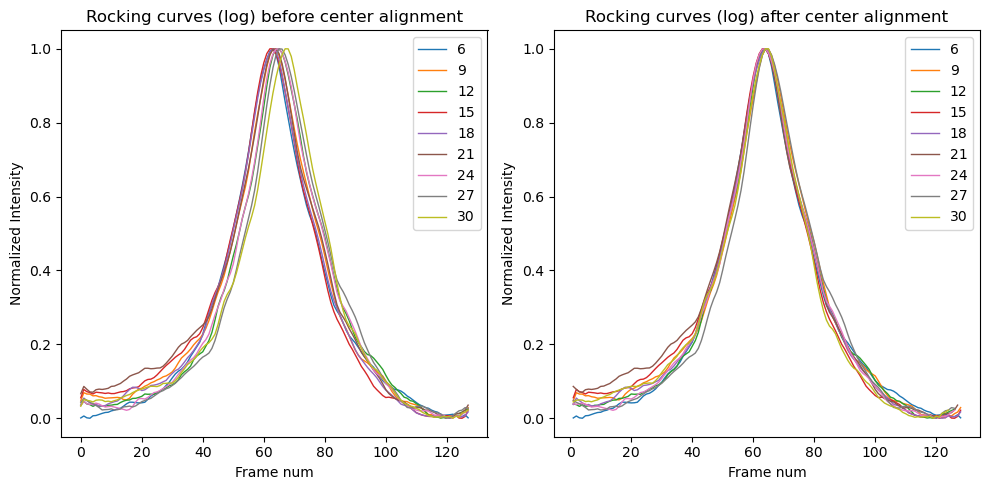

In [5]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].set_title('Rocking curves (log) before center alignment')
ax[0].set_xlabel('Frame num')
ax[0].set_ylabel('Normalized Intensity')
ax[1].set_title('Rocking curves (log) after center alignment')
ax[1].set_xlabel('Frame num')
ax[1].set_ylabel('Normalized Intensity')

rc_emc_log = []
for scan in emc_scan_numbers:
    data_emc_file = EMC_file + 'corr_%i_05_5e3_128.npz'%scan
    data_emc_temp_ = np.load(data_emc_file)['W'][:]
    rc_emc_temp_ = np.sum(data_emc_temp_, axis=(1,2))
    rc_emc_log.append(normalize_1d(np.log10(rc_emc_temp_)))
    ax[0].plot(normalize_1d(np.log10(rc_emc_temp_)), label='%i'%scan, linewidth=1)

peak_pos_rc = np.argmax(rc_emc_log, axis=1)
shift = peak_pos_rc - peak_pos_rc[0]
frame_num = np.linspace(1, len(rc_emc_temp_), len(rc_emc_temp_))
print(shift, len(frame_num))

for i, scan in enumerate(emc_scan_numbers):
    shift_temp_ = shift[i]
    rc_emc_log_temp_ = rc_emc_log[i]
    frame_num_temp_ = np.copy(frame_num)
    if shift_temp_ < 0:
        rc_emc_log_temp_ = rc_emc_log_temp_[:-shift_temp_]
        frame_num_temp_ = frame_num_temp_[shift_temp_:]
    elif shift_temp_ > 0:
        rc_emc_log_temp_ = rc_emc_log_temp_[shift_temp_:]
        frame_num_temp_ = frame_num_temp_[:-shift_temp_]
    ax[1].plot(frame_num_temp_,rc_emc_log_temp_, label='%i'%scan, linewidth=1)
    
ax[0].legend()
ax[1].legend()
plt.tight_layout()

### derivation distribution (Trajectory)

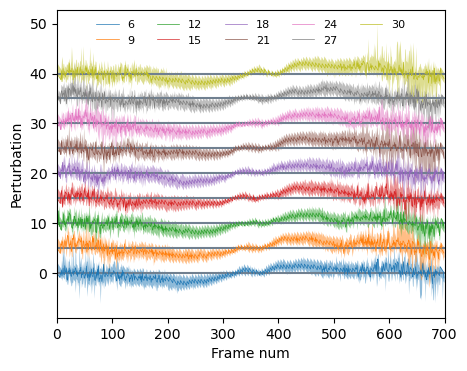

In [45]:
fig, ax = plt.subplots(1,1, figsize=(5, 4))

step = 5
threshold = 1e-2
flip = 0

frame_num_ = np.linspace(1, len(rc_emc_temp_), 700)
frame_num_0 = np.linspace(1, 700, 700)

for i, scan in enumerate(emc_scan_numbers):
    data_emc_file = EMC_file + 'corr_%i_05_5e3_128.npz'%scan
    Pjk_data_ = np.load(data_emc_file)['Pjk'][:]

    up_limit = np.zeros(len(frame_num_))
    bottom_limit = np.zeros(len(frame_num_))
    trajectory = np.zeros(len(frame_num_))
    
    for j in range(Pjk_data_.shape[1]):
        pos_ = np.where(Pjk_data_[:, j] > threshold)[0]
        
        pos_up_ = pos_.min()
        pos_bottom_ = pos_.max()
        up_limit[j] = frame_num[pos_up_]
        bottom_limit[j] = frame_num[pos_bottom_]

        pos_max_ = np.argmax(Pjk_data_[:, j])
        trajectory[j] = frame_num[pos_max_]

    if flip:
        up_limit = np.flip(up_limit)
        bottom_limit = np.flip(bottom_limit)
        trajectory = np.flip(trajectory)

    up_limit_ =up_limit - frame_num_
    bottom_limit_ = bottom_limit - frame_num_
    trajectory_ = trajectory - frame_num_

    ax.axhline(y=0 + step * i, color='slategray')
    ax.plot(trajectory_ + step * i, linewidth=0.5, alpha=1, label='%i'%scan)
    line = ax.fill_between(frame_num_0, up_limit_ + step * i, bottom_limit_ + step * i, interpolate=True, alpha=0.5)

ax.set_xlim([0, 700])
ax.set_xlabel('Frame num')
ax.set_ylabel('Perturbation')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=5, frameon=False, prop={'size': 8})


    



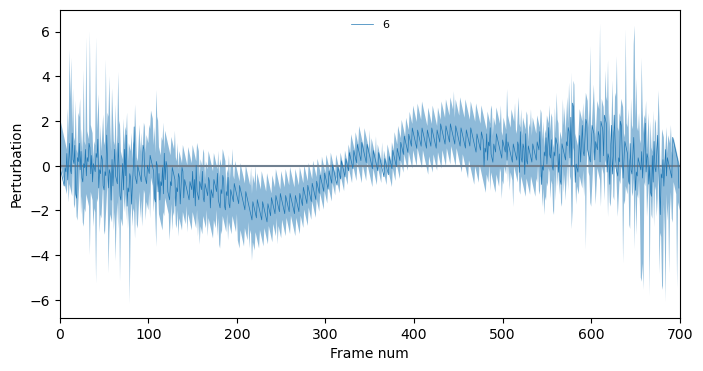

In [48]:
fig, ax = plt.subplots(1,1, figsize=(8, 4))

scan = 6

step = 5
threshold = 1e-2
flip = 0

frame_num_ = np.linspace(1, len(rc_emc_temp_), 700)
frame_num_0 = np.linspace(1, 700, 700)

data_emc_file = EMC_file + 'corr_%i_05_5e3_128.npz'%scan
Pjk_data_ = np.load(data_emc_file)['Pjk'][:]

up_limit = np.zeros(len(frame_num_))
bottom_limit = np.zeros(len(frame_num_))
trajectory = np.zeros(len(frame_num_))

for j in range(Pjk_data_.shape[1]):
    pos_ = np.where(Pjk_data_[:, j] > threshold)[0]
    
    pos_up_ = pos_.min()
    pos_bottom_ = pos_.max()
    up_limit[j] = frame_num[pos_up_]
    bottom_limit[j] = frame_num[pos_bottom_]

    pos_max_ = np.argmax(Pjk_data_[:, j])
    trajectory[j] = frame_num[pos_max_]

if flip:
    up_limit = np.flip(up_limit)
    bottom_limit = np.flip(bottom_limit)
    trajectory = np.flip(trajectory)

up_limit_ =up_limit - frame_num_
bottom_limit_ = bottom_limit - frame_num_
trajectory_ = trajectory - frame_num_

ax.axhline(y=0 , color='slategray')
ax.plot(trajectory_ , linewidth=0.5, alpha=1, label='%i'%scan)
line = ax.fill_between(frame_num_0, up_limit_, bottom_limit_, interpolate=True, alpha=0.5)

ax.set_xlim([0, 700])
ax.set_xlabel('Frame num')
ax.set_ylabel('Perturbation')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=5, frameon=False, prop={'size': 8})